# Centers of coffee - report

## Part 1 - Business Problem

An imaginary global coffee company is interested in entering a new city, they have decided to open coffee shops to compete with all the local vendors. They want to open the new shops as close as possible to the competition in order to have the cheapest prices in the area and run the competition out of business.  They have come to me to ask for a geographical analysis, to find the perfect place for their shops. The coffee shop industry is worth over 100 billion dollars and is growing fast.

## part 2 - data

The data will be obtained by the foursquare API, I’ll be looking for geolocation data of all coffee shops and café’s in Rome, and I will be applying k-means algorithms to this data in order to find the locations that minimize the distance to all coffee shops and café’s. 

In this part I'll gather the data.

In [1]:
#importing pandas, numpy and relevant libraries
import pandas as pd
import numpy as np

In [2]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: ...working... done

# All requested packages already installed.



In [3]:
# import geocoder - a library for geolocation data
!conda install -c conda-forge geocoder --yes 
import geocoder 
import time
import requests 


Solving environment: ...working... done

# All requested packages already installed.



In [4]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [5]:
#hiden cell
#Foursquare credentials


In [6]:

#using API to try get all coffe shops and cafe's
radius = 3500 # define radius
LIMIT = 1500 # limit of number of venues returned by Foursquare API
categoryId = "4bf58dd8d48988d16d941735,4bf58dd8d48988d1e0931735" #Cafe,coffe shop category ID in Foursquare API
location = "Rome"

# create URL

url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}'.format(
    categoryId,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    location,
    radius, 
    LIMIT)
results = requests.get(url).json()
#results

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
#making a data frame 
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # normalize JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Bar Trani,Café,41.893034,12.505343
1,Molino,Café,41.896590,12.499325
2,The British Corner,Tea Room,41.888204,12.531285
3,Nespresso Boutique,Coffee Shop,41.885203,12.509556
4,Caffè Ciamei,Café,41.892193,12.505640


In [9]:
#looking at the veneus
Location = [41.9, 12.5]
map_cafe = folium.Map(location=Location, zoom_start=11)

# add markers to map
for lat, lng, name in zip(nearby_venues['lat'],
                          nearby_venues['lng'],
                          nearby_venues['name']):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cafe) 
map_cafe

Looks like we are not getting all of Rome

In [10]:
nearby_venues.shape

(100, 4)

Only 100 venues, not 1500 like the limit I stated. Foursquare API only returns up to 100 in a querie. I think I need multiple queries in order to get all of them.

I'll build a grid to run multiple searches and then merge the results

In [11]:
grid = [(i/50 - 0.1 ,j/50 - 0.1) for i in range(11) for j in range(11)]

In [12]:
#looking at the veneus
Location = [41.9, 12.5]
map_cafe = folium.Map(location=Location, zoom_start=11)

# add markers to map
for ll in grid:
    label = "name"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Location[0] + ll[0], Location[1] + ll[1]],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cafe) 
map_cafe

The grid covers rome like i wanted. Now I'll run multyple surches in Foursquare to get all the coffe shops of rome

In [13]:
#using API to get all coffe shops and cafe's
radius = 3500 # define radius
LIMIT = 500 # limit of number of venues returned by Foursquare API
categoryId = "4bf58dd8d48988d16d941735,4bf58dd8d48988d1e0931735" #Cafe,coffe shop category ID in Foursquare API
location = "Rome"
df = pd.DataFrame(columns =  ['name', 'categories', 'lat', 'lng'])

# create URL
for ll in grid:
    url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        categoryId,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        ll[0] + 41.9,
        ll[1] + 12.5,
        radius, 
        LIMIT)
    results = requests.get(url).json()
    #time.sleep(1)

    #making a data frame 
    venues = results['response']['groups'][0]['items']

    nearby_venues = json_normalize(venues) # normalize JSON
    
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    if 'venue.name' in nearby_venues.columns:
        nearby_venues =nearby_venues.loc[:, filtered_columns]

        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

        # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        df = pd.merge(df, nearby_venues, on= ['name', 'categories', 'lat', 'lng'],how='outer')


df.head()

,name,categories,lat,lng
0,Bar Dal Pannocchia,Café,41.796270,12.407022
1,Mondo Gelo,Café,41.783271,12.435756
2,BarCode,Café,41.796178,12.432368
3,Bar Bucchi,Café,41.786176,12.383650
4,Red Cafe At Un World Food Programme,Café,41.821181,12.408381


In [14]:
df.shape

(801, 4)

In [15]:
#looking at the veneus
Location = [41.9, 12.5]
map_cafe = folium.Map(location=Location, zoom_start=11)

# add markers to map
for lat, lng, name in zip(df['lat'],
                          df['lng'],
                          df['name']):
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cafe) 
map_cafe

Good! we have all the data, next part will be to apply k-means to this data

## part 3 analysis


In this part I'll use k-means to determine the perfect place in Rome to open large coffee shops and how many should the company open.

First, to determine the k I’ll use the elbow method.


In [16]:
#impotring k-means and data visualisation libraries
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  
import matplotlib.cm as cm
import matplotlib.colors as colors

In [17]:
# using the elbow method to determine the beast k

X = df.drop(['name',"categories"], 1)

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,11)
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

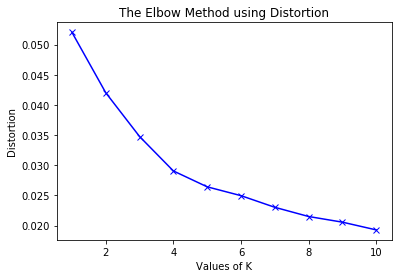

In [18]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

By the elbow Method I see that 4 is the best k.

In [19]:
kclusters = 4

kmeans = KMeans(n_clusters=kclusters).fit(X) 
kmeans.fit(X)  

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [20]:
#adding Cluster Labels to the dataframe 
df.insert(0, 'Cluster Labels', kmeans.labels_)


In [21]:
df.head()

,Cluster Labels,name,categories,lat,lng
0,2,Bar Dal Pannocchia,Café,41.796270,12.407022
1,2,Mondo Gelo,Café,41.783271,12.435756
2,2,BarCode,Café,41.796178,12.432368
3,2,Bar Bucchi,Café,41.786176,12.383650
4,2,Red Cafe At Un World Food Programme,Café,41.821181,12.408381


In [22]:
Location = [41.9, 12.5]

map_clusters = folium.Map(location=Location, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['lat'], df['lng'],
                                  df['name'], df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can see the clusters, now let's find the centroids.

In [23]:
centroids  = kmeans.cluster_centers_
centroids

array([[41.90665813, 12.45704291],
       [41.87263848, 12.58416283],
       [41.83575347, 12.46986395],
       [41.91257958, 12.51204052]])

In [24]:
#looking at the centroids
Location = [41.9, 12.5]
map_cafe = folium.Map(location=Location, zoom_start=11)

# add markers to map
for ll in centroids:
    label = "name"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [ll[0],ll[1]],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff0000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cafe) 
map_cafe

This is what I wanted to find. 